# Setup Notebook

In [1]:
# When working in AI LRZ
%cd ~/cma/CMA_Fairness_v2

/dss/dsshome1/0C/ra93lal2/cma/CMA_Fairness_v2


/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
%run analysis_setup_cp.ipynb

/dss/dsshome1/0C/ra93lal2/cma/CMA_Fairness_v2
The data has N = 100 rows and N = 12 columns.


## Prepare Data


In [ ]:
# Filter out a single configuration to keep data manageable
#df_agg = df_agg_full[
#  (df_agg_full["sett_eval_fairness_grouping"] == "nationality-all") #&
#  #(df_agg_full["sett_eval_exclude_subgroups"] == "keep-in-eval") &
#  #(df_agg_full["sett_eval_on_subset"] == "full")
#][
#  # Remove eval columns
#  cols_non_eval + cols_performance + cols_fairness
#].reset_index(drop = True)
#
#df_agg.shape

In [3]:
import pandas as pd
from pathlib import Path

RUN_TO_ANALYSE = "6"
CP_DIR = Path("output") / "runs" / str(RUN_TO_ANALYSE)

df_agg = pd.read_csv(CP_DIR / "combined_cp_metrics.csv")

In [4]:
df_agg.head()

,universe_id,universe_model,universe_exclude_features,universe_exclude_subgroups,universe_scale,q_hat,coverage,avg_size,cov_frau1,cov_nongerman,cov_nongerman_male,cov_nongerman_female
0,20d6fedaf26cae7661ca03d7da38f220,logreg,nationality,keep-all,scale,0.659520,0.910244,1.124980,0.909044,0.912031,0.928037,0.885544
1,e45e5b79b986d17a53c94d3c04261c87,rf,sex,drop-non-german,scale,0.650000,0.913978,1.139282,0.913304,0.908494,0.923174,0.884203
2,0a44548818219cb72629c2cf8cd62c10,rf,nationality-sex,drop-non-german,scale,0.650000,0.914335,1.140999,0.912684,0.908774,0.923444,0.884501
3,8631657b183932ecdcc601e19df5cb9f,penalized_logreg,none,keep-all,do-not-scale,0.673672,0.912161,1.203768,0.911794,0.931848,0.943889,0.911923
4,7835d6f4276d464df5313c642496b1e0,logreg,nationality,drop-non-german,do-not-scale,0.673981,0.910779,1.212853,0.910338,0.936282,0.947762,0.917288


In [5]:
df_agg.shape

(100, 12)

In [6]:
main_cp_metric = "cov_nongerman_female" # "avg_size", "cov_nongerman_female"

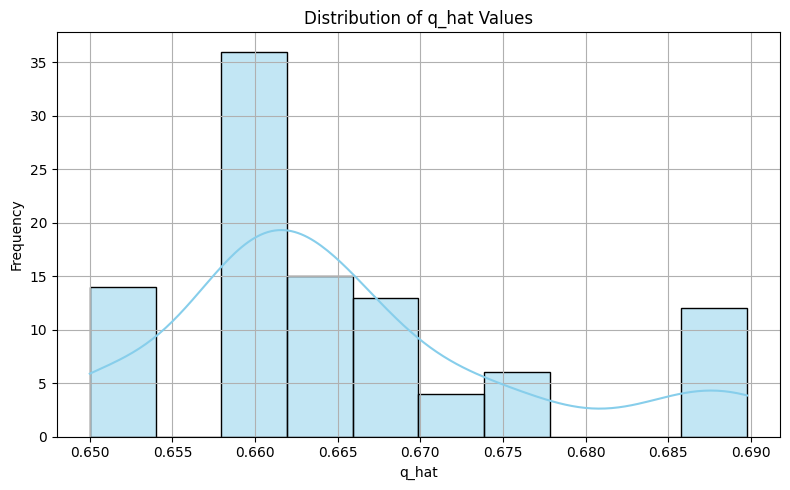

In [7]:
#import matplotlib.pyplot as plt
#import seaborn as sns
#
## Plot distribution of q_hat
#plt.figure(figsize=(8, 5))
#sns.histplot(df_agg["q_hat"], bins=10, kde=True, color="skyblue")
#plt.title("Distribution of q_hat Values")
#plt.xlabel("q_hat")
#plt.ylabel("Frequency")
#plt.grid(True)
#plt.tight_layout()
#plt.show()

# Calculate Variable Importance

## Use a Lasso Regression to estimate Importance of Settings

In [8]:
X = df_agg[["universe_model", "universe_exclude_features", "universe_exclude_subgroups", "universe_scale"]]
y = df_agg[main_cp_metric]

In [9]:
X.head()

,universe_model,universe_exclude_features,universe_exclude_subgroups,universe_scale
0,logreg,nationality,keep-all,scale
1,rf,sex,drop-non-german,scale
2,rf,nationality-sex,drop-non-german,scale
3,penalized_logreg,none,keep-all,do-not-scale
4,logreg,nationality,drop-non-german,do-not-scale


In [10]:
X.shape

(100, 4)

In [11]:
y.shape

(100,)

### Main Effects of Settings Only (i.e. no interactions)

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LassoCV

# Do preprocessing in a separate pipeline from model fitting
# (for eli5 to work)
preprocessor = make_pipeline(
    OneHotEncoder(), # Converts categorical features to one-hot encoded format
).fit(X) # Fit the preprocessing pipeline to the input data X
X_processed = preprocessor.transform(X) # This creates a numeric matrix suitable for modeling

# Fit a Lasso regression model with cross-validation to the processed data
lasso_reg = LassoCV(cv=5, random_state=0).fit(X_processed, y)

# Check whether it's predictive at all
lasso_reg.score(X_processed, y) # Evaluate the model's R^2 score on the training data


0.4714542462085004

R² = 1.0: Perfect predictions

R² = 0.0: Model does no better than predicting the mean

R² < 0.0: Model is worse than just predicting the mean

Weights of importance:

In [13]:
# Visualize the importance of each feature in trained lasso_reg model
import eli5
eli5.show_weights(lasso_reg, top=-1, feature_names = preprocessor.get_feature_names_out())


Weight?,Feature
+0.879,<BIAS>
+0.015,universe_scale_do-not-scale
+0.011,universe_model_penalized_logreg
+0.011,universe_model_logreg
+0.008,universe_exclude_features_age
-0.000,universe_scale_scale
-0.003,universe_model_rf
-0.003,universe_model_gbm


### Including Interactions

In [14]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LassoCV

# Do preprocessing w/o a pipeline for eli5 to work
preprocessor = make_pipeline(
    OneHotEncoder(),
    PolynomialFeatures(degree=2),
).fit(X)
X_processed = preprocessor.transform(X)

lasso_reg = LassoCV(cv=5, random_state=0).fit(X_processed, y)

# Check whether it's predictive at all
lasso_reg.score(X_processed, y) # Evaluate the model's R^2 score on the training data


0.8906850190928847

Weights of importance:

In [15]:
import eli5
eli5.show_weights(lasso_reg, top=-1, feature_names = preprocessor.get_feature_names_out())


Weight?,Feature
+0.885,<BIAS>
+0.030,universe_exclude_features_age universe_scale_do-not-scale
+0.027,universe_model_penalized_logreg universe_scale_do-not-scale
+0.027,universe_model_logreg universe_scale_do-not-scale
+0.007,universe_model_elasticnet universe_exclude_features_age
+0.001,universe_model_gbm universe_scale_scale
+0.001,universe_exclude_subgroups_drop-non-german universe_scale_do-not-scale
+0.001,universe_model_rf universe_scale_scale
+0.001,universe_exclude_features_sex^2
+0.000,universe_exclude_features_age universe_exclude_subgroups_keep-all


## Use a functinoal ANOVA (fANOVA) to Analyze Setting Importance

Based on the following paper:

Hutter, F., Hoos, H., & Leyton-Brown, K. (2014). An Efficient Approach for Assessing Hyperparameter Importance. Proceedings of the 31st International Conference on Machine Learning, 754–762. https://proceedings.mlr.press/v32/hutter14.html


In [16]:
from fairness_multiverse.analysis import MultiverseFanova

m_fanova = MultiverseFanova(features = df_agg[["universe_model", "universe_exclude_features", "universe_exclude_subgroups", "universe_scale"]], outcome = df_agg[main_cp_metric])


In [17]:
m_fanova.quantify_individual_importance()

,individual importance,total importance,individual std,total std
universe_exclude_features,0.048511,0.048511,0.035576,0.035576
universe_exclude_subgroups,0.004593,0.004593,0.009103,0.009103
universe_model,0.241521,0.241521,0.059690,0.059690
universe_scale,0.207402,0.207402,0.065705,0.065705


In [18]:
m_fanova.quantify_importance(save_to = "fanova_importance_interactions-overall_alpha_2.csv")

,level_0,level_1,level_2,level_3,individual importance,total importance,individual std,total std
2,universe_model,NaN,NaN,NaN,0.241521,0.241521,0.059690,5.969013e-02
3,universe_scale,NaN,NaN,NaN,0.207402,0.207402,0.065705,6.570506e-02
9,universe_model,universe_scale,NaN,NaN,0.202555,0.651477,0.084399,1.268687e-01
12,universe_exclude_features,universe_model,universe_scale,NaN,0.078508,0.925674,0.035602,1.080051e-01
5,universe_exclude_features,universe_model,NaN,NaN,0.076931,0.366963,0.047866,8.617447e-02
6,universe_exclude_features,universe_scale,NaN,NaN,0.070247,0.326159,0.040559,7.713765e-02
0,universe_exclude_features,NaN,NaN,NaN,0.048511,0.048511,0.035576,3.557587e-02
13,universe_exclude_subgroups,universe_model,universe_scale,NaN,0.017024,0.692005,0.027215,1.203113e-01
7,universe_exclude_subgroups,universe_model,NaN,NaN,0.013664,0.259777,0.025090,7.027036e-02
10,universe_exclude_features,universe_exclude_subgroups,universe_model,NaN,0.012936,0.404645,0.022492,1.014116e-01


In [19]:
# Format

cols_to_format = [
    "individual importance",
    "total importance",
    "individual std",
    "total std"
]

fanova_interactions = m_fanova.quantify_importance()
fanova_interactions[cols_to_format] = fanova_interactions[cols_to_format].applymap(lambda x: f"{x:.4f}")
fanova_interactions

,level_0,level_1,level_2,level_3,individual importance,total importance,individual std,total std
2,universe_model,NaN,NaN,NaN,0.2415,0.2415,0.0597,0.0597
3,universe_scale,NaN,NaN,NaN,0.2074,0.2074,0.0657,0.0657
9,universe_model,universe_scale,NaN,NaN,0.2026,0.6515,0.0844,0.1269
12,universe_exclude_features,universe_model,universe_scale,NaN,0.0785,0.9257,0.0356,0.1080
5,universe_exclude_features,universe_model,NaN,NaN,0.0769,0.3670,0.0479,0.0862
6,universe_exclude_features,universe_scale,NaN,NaN,0.0702,0.3262,0.0406,0.0771
0,universe_exclude_features,NaN,NaN,NaN,0.0485,0.0485,0.0356,0.0356
13,universe_exclude_subgroups,universe_model,universe_scale,NaN,0.0170,0.6920,0.0272,0.1203
7,universe_exclude_subgroups,universe_model,NaN,NaN,0.0137,0.2598,0.0251,0.0703
10,universe_exclude_features,universe_exclude_subgroups,universe_model,NaN,0.0129,0.4046,0.0225,0.1014


In [ ]:
best_p_margs = m_fanova.fanova.get_most_important_pairwise_marginals(n=5)
print(best_p_margs)

In [ ]:
# Directory that will contain outputs from analysis

from pathlib import Path

ANALYSIS_OUTPUT_DIR = Path(".") / "analyses"
ANALYSIS_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
from fanova import visualizer

vis = visualizer.Visualizer(m_fanova.fanova, m_fanova.configuration_space, directory = str(ANALYSIS_OUTPUT_DIR))

In [ ]:
vis.plot_marginal(0)

In [ ]:
vis.plot_pairwise_marginal(['universe_exclude_features', 'universe_exclude_subgroups'])

## Quantify Importance with Partial Data

In [ ]:
from tqdm import tqdm

PARTIAL_FANOVA_DIR = ANALYSIS_OUTPUT_DIR / "partial_fanova" / "overall"
PARTIAL_FANOVA_DIR.mkdir(parents=True, exist_ok=True)

N_ITERATIONS = 10

In [ ]:
from fairness_multiverse.analysis import MultiverseFanova
import joblib

def quantify_importance_for_fraction(fraction: float, base_directory = PARTIAL_FANOVA_DIR):
    # Get random subset of the data
    df = df_agg.sample(frac = fraction).reset_index(drop = True)
    data_hash = joblib.hash(df)

    # Create directory for this fraction
    directory = base_directory / f"fraction-{fraction}"
    directory.mkdir(exist_ok = True)

    # Run FANOVA on subset
    partial_fanova = MultiverseFanova(features = df[["universe_model", "universe_exclude_features", "universe_exclude_subgroups"]], outcome = df[main_cp_metric])
    partial_fanova.quantify_importance(save_to = directory / f"partial-fanova_importance_interactions-majmin-{fraction}-{data_hash}.csv")

In [ ]:
for i in tqdm(range(N_ITERATIONS)):
    quantify_importance_for_fraction(0.01)

In [ ]:
for i in tqdm(range(N_ITERATIONS)):
    quantify_importance_for_fraction(0.05)

In [ ]:
for i in tqdm(range(N_ITERATIONS)):
    quantify_importance_for_fraction(0.1)

In [ ]:
for i in tqdm(range(N_ITERATIONS)):
    quantify_importance_for_fraction(0.2)